In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from scipy.interpolate import interp2d
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from labellines import labelLine
from PIL import Image
import geopandas as gpd

In [4]:
cities_populations = pd.DataFrame(columns=['city', 'population'])
for name in ['miami', 'ma', 'bogota', 'dallas', 'austin', 'detroit', 'ny', 'baltimore']:
    pop = pd.read_csv(f'confinement/cities3/{name}/Poparea.txt', sep=' ', header=None)[1].sum()
    cities_populations = pd.concat([cities_populations, pd.DataFrame([[name, pop]], columns=['city', 'population'])])
cities_populations = cities_populations.set_index('city')['population']
cities_populations

city
miami         5590269
ma            4146213
bogota        7129506
dallas        6464479
austin        1775659
detroit       4475286
ny           12423494
baltimore     2769977
Name: population, dtype: object

In [5]:
EPSG = 'EPSG:21897'
impact_path = "figures/impact_map"
links_path = "figures/links_map"

impact_Norm = Normalize()

ZAT_index = pd.read_csv(f"{impact_path}/bogota/zat_index.txt", sep=" ", header=None, names=["ZAT", "index"])
ZAT = gpd.read_file(f"{impact_path}/bogota/ZAT/ZAT.shp")[['ZAT', 'geometry']].to_crs(EPSG)
ZAT = ZAT.merge(ZAT_index, on="ZAT")

zcta = gpd.read_parquet('zcta.parquet')

# zcta = gpd.read_file(f'{impact_path}/geo/zcta510/tl_2020_us_zcta510.shp')
# zcta = zcta.astype({'ZCTA5CE10': 'int64'})

statename = 'ma'
city = 'ma'

states_fips = pd.read_csv(f'{impact_path}/geo/states_fips.txt',sep=',', index_col=0)
statefip = states_fips.loc[statename,'FIPS']


zcta_index = pd.read_csv(f'{impact_path}/cities3/'+city+'/zcta_index.csv', sep=' ')#.reset_index() 
zcta_index = zcta.merge(zcta_index, left_on='ZCTA5CE10', right_on='zcta')
zcta_index = zcta_index.sort_values('zcta_index')[['zcta', 'zcta_index', 'geometry']].rename(columns={'zcta_index':'index'})

# Fig 3

In [27]:
def plot_attackRate_nus(ax1):
    label_size = 16
    abc_size = 16*1.6

    beta_max,beta_min = 4, 1
    name = 'bogota'

    beta = 3

    heatmap100 = pd.read_csv(f'confinement/out/attackRateMap/{name}_p_1,0nu_1,00_beta_1-4.txt', sep='\t')
    try:
        heatmap050 = pd.read_csv(f'confinement/out/attackRateMap/{name}_p_1,0nu_0,50_beta_3.txt', sep='\t')
        heatmap025 = pd.read_csv(f'confinement/out/attackRateMap/{name}_p_1,0nu_0,25_beta_3.txt', sep='\t')
    except:
        heatmap050 = pd.read_csv(f'confinement/out/attackRateMap/{name}_p_1,0nu_0,50_beta_1-4.txt', sep='\t')
        heatmap025 = pd.read_csv(f'confinement/out/attackRateMap/{name}_p_1,0nu_0,25_beta_1-4.txt', sep='\t')



    heatmap100 = heatmap100[heatmap100['beta'] == beta]
    heatmap050 = heatmap050[heatmap050['beta'] == beta]
    heatmap025 = heatmap025[heatmap025['beta'] == beta]

    heatmap100['attackRate'] = heatmap100['attackRate'] / cities_populations.loc[name]
    heatmap050['attackRate'] = heatmap050['attackRate'] / cities_populations.loc[name]
    heatmap025['attackRate'] = heatmap025['attackRate'] / cities_populations.loc[name]


    linearColor = mpl.colormaps['inferno']
        
    ax1.plot('links', 'attackRate', data=heatmap100, color=linearColor(0.0), label=fr'$\eta = {1.0:.2f}$')
    ax1.plot('links', 'attackRate', data=heatmap050, color=linearColor(0.25), label=fr'$\eta = {0.50:.2f}$')
    ax1.plot('links', 'attackRate', data=heatmap025, color=linearColor(0.5), label=fr'$\eta = {0.25:.2f}$')

    ax1.legend(title_fontsize=label_size, fontsize=label_size*0.8, loc='upper center')

    # labelLines(plt.gca().get_lines(), zorder=2.5, xvals=(26000, 14000), outline_width=5, fontsize=10)

    ax1.set_xlabel('L', size=label_size)
    ax1.set_ylabel('Attack Rate', size=label_size)
    ax1.tick_params(labelsize=label_size)
    ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    # ax1.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
    # ax1.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
    ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
    ax1.xaxis.offsetText.set_fontsize(label_size*0.8)
    ax1.yaxis.offsetText.set_fontsize(label_size*0.8)


    ax1.grid('True')
    ax1.set_ylim(0,)
    # ax1.set_xlim(,)

def plot_attackRate_miami(ax1):

    label_size = 16
    abc_size = 16*1.6

    beta_max,beta_min = 4, 1
    name = 'miami'

    heatmap = pd.read_csv(f'confinement/out/attackRateMap/{name}_p_0,9nu_1,00_beta_1-4.txt', sep='\t')
    #concatenate the dataframes

    heatmap = heatmap[(heatmap['beta'] <= beta_max) & (heatmap['beta'] >= beta_min)]
    heatmap['attackRate'] = heatmap['attackRate'] / cities_populations.loc[name]


    pivotTable = pd.pivot_table(data = heatmap, index = 'beta', columns = 'links', values='attackRate')

    linearColor = mpl.colormaps['inferno_r']
    for i,val in enumerate(heatmap['beta'].drop_duplicates()):
        links_text = 11472
        color=linearColor((val-beta_min)/(beta_max-beta_min))
        ax1.plot('links', 'attackRate', data=heatmap[heatmap['beta']==val], color=color, label=f'{val:.1f}')
        # ax1.text(links_text, heatmap[(heatmap['beta']==val) & (heatmap['links']==links_text)]['attackRate'].max(),
        #         r'$R_0$ = ' + f'{val:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=1, pad=-1), ha='center', va='center')

    labelLines(plt.gca().get_lines(), zorder=2.5, xvals=(26000, 14000), outline_width=5, fontsize=10)

    # COLORBAR
    sm = plt.cm.ScalarMappable(cmap=linearColor, norm=Normalize(vmin=beta_min, vmax=beta_max))
    #sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1)

    ax1.set_xlabel('Links', size=label_size)
    ax1.set_ylabel('Attack Rate', size=label_size)
    ax1.tick_params(labelsize=label_size)
    ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    # ax1.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
    # ax1.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
    ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
    ax1.xaxis.offsetText.set_fontsize(label_size*0.8)
    ax1.yaxis.offsetText.set_fontsize(label_size*0.8)

    cbar.ax.tick_params(labelsize=label_size)
    cbar.ax.set_ylabel(r'$R_0$', size=label_size)

    ax1.grid('True')
    ax1.set_ylim(0,)
    ax1.set_xlim()


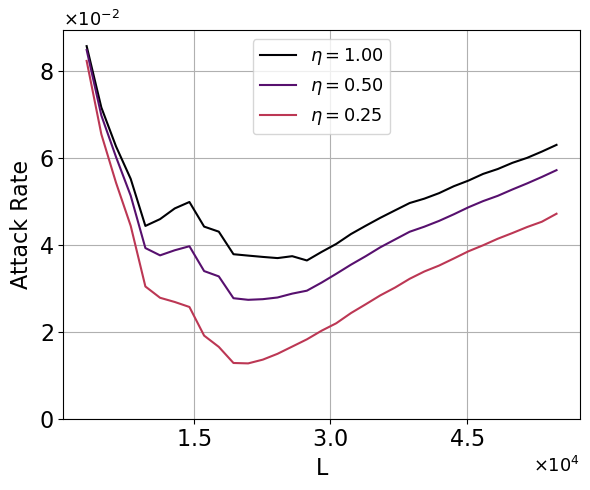

In [28]:
fig,ax = plt.subplots(figsize=(6, 5))
plot_attackRate_nus(ax)

fig.tight_layout(h_pad=-2.0, w_pad=0)

In [29]:
# fig.savefig('figures/figs_aug24/confinement/miami_p_0,9nu_1,00.pdf', dpi=300, bbox_inches='tight')
fig.savefig('figures/figs_aug24/confinement/bogota_p_1,0nus.pdf', dpi=300, bbox_inches='tight')


# Fig 4

In [9]:
label_size = 16
abc_size = 16*1.6


def plot_EWT_betas(ax, name):
    colormap = mpl.colormaps['viridis']

    betas = ['2,0','3,0', '4,0']
    betas_pt = ['2.0', '3.0', '4.0']
    for i,betastr in enumerate(betas):
        try:
            heatmap = pd.read_csv('times/out/' + name + f'_{20}k_120d_p_1,0nu_1,00_beta_' + betastr +
                                '.txt', sep='\t')
        except:
            try:
                heatmap = pd.read_csv('times/out/' + name + f'_{20}k_60d_p_1,0nu_1,00_beta_' + betastr +
                                '.txt', sep='\t')
            except:
                continue
        heatmap['time'] = heatmap['time'].rolling(window=2).mean()
        heatmap['time_error'] = heatmap['time_error'].rolling(window=2).mean()
        heatmap['time_error'] = heatmap['time_error']/np.sqrt(23) * 1.96

        #rolling average of data
        color = colormap(i/3)
        ax.plot('links', 'time', data=heatmap, color=color, lw=2, label = r'$R_0 = $' + str(betas_pt[i]))
        ax.fill_between(x=heatmap['links'], y1=heatmap['time']+ 1*heatmap['time_error'], y2=heatmap['time']-1*heatmap['time_error'], color=color, alpha=0.2)

    ax.legend(fontsize=label_size*0.8, loc = 'lower right')
    ax.set_xlabel('Links', size=label_size)
    ax.set_ylabel('EWT (days)', size=label_size)
    ax.tick_params(labelsize=label_size)
    ax.set_xlim(0,)
    ax.set_ylim(0,65)
    ax.grid('True')
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

def plot_EWT_etas(ax, name):
    colormap = mpl.colormaps['viridis']

    etas = ['1,00','0,50','0,25']
    etas_pt = ['1.0', '0.50', '0.25']
    betastr = '4,0'
    for i,etastr in enumerate(etas):
        try:
            heatmap = pd.read_csv('times/out/' + name + f'_{20}k_120d_p_1,0nu_{etastr}_beta_' + betastr +
                                '.txt', sep='\t')
        except:
            try:
                heatmap = pd.read_csv('times/out/' + name + f'_{20}k_60d_p_1,0nu_{etastr}_beta_' + betastr +
                                '.txt', sep='\t')
            except:
                continue
        heatmap['time'] = heatmap['time'].rolling(window=2).mean()
        heatmap['time_error'] = heatmap['time_error'].rolling(window=2).mean()
        heatmap['time_error'] = heatmap['time_error']/np.sqrt(23) * 1.96

        #rolling average of data
        color = colormap(i/3)
        ax.plot('links', 'time', data=heatmap, color=color, lw=2, label = r'$\eta = $' + str(etas_pt[i]))
        ax.fill_between(x=heatmap['links'], y1=heatmap['time']+ 1*heatmap['time_error'], y2=heatmap['time']-1*heatmap['time_error'], color=color, alpha=0.2)

    ax.legend(fontsize=label_size*0.8, loc = 'lower right')
    ax.set_xlabel('Links', size=label_size)
    ax.set_ylabel('EWT (days)', size=label_size)
    ax.tick_params(labelsize=label_size)
    ax.set_xlim(0,)
    ax.set_ylim(0,65)
    ax.grid('True')
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

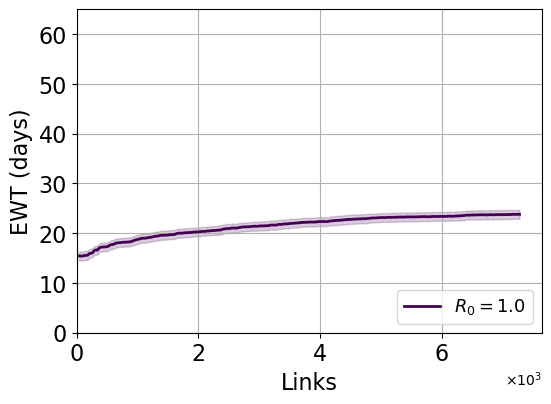

In [10]:
fig,ax=plt.subplots(figsize=(6,4.2))
name = 'austin'
plot_EWT_etas(ax, name)
# fig.savefig(f'figures/figs_aug24/times/{name}_p_1,0_beta_4,0.pdf', bbox_inches='tight')



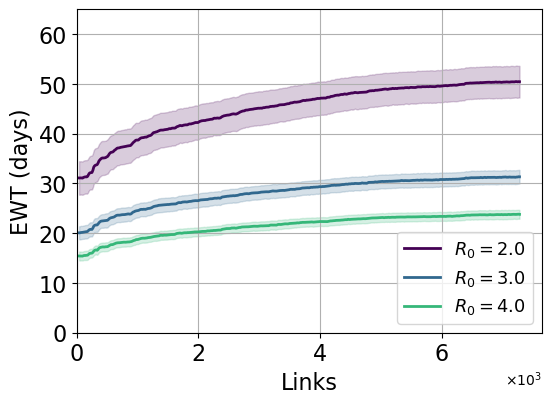

In [68]:
fig,ax=plt.subplots(figsize=(6,4.2))
name = 'austin'
plot_EWT_betas(ax, name)
fig.savefig(f'figures/figs_aug24/times/{name}_p_1,0nu_1,00.pdf', bbox_inches='tight')



In [128]:
label_size = 16
abc_size = 16*1.6

colormap = mpl.colormaps['viridis_r']

name = 'bogota'
betastr = '4,0'

def plot_infected_time_bogota_reductionR0(ax):
    curves = pd.read_csv('curves_times_reduction_R0/out/bogota_20k_180d_beta_4,0(bis).txt', sep='\t')
    links_list = curves['links'].drop_duplicates().sort_values()
    

    curves['error_infected'] = 1.98 * curves['error_infected'] / np.sqrt(24-1)
    
    # curves['cumulative_infected'] = curves.groupby('links')['infected'].cumsum(axis=0)
    for link in links_list:
        ax.plot('time', 'infected', data = curves[curves['links']==link], lw=2, 
                color = colormap(link/links_list.max()), label = r'$L = $' + '{:.0f}'.format(link/1000) +r'$\times 10^3$')
        #plot errors
        ax.fill_between(x=curves[curves['links']==link]['time'], y1=curves[curves['links']==link]['infected']+ curves[curves['links']==link]['error_infected'],
            y2=curves[curves['links']==link]['infected']-curves[curves['links']==link]['error_infected'], color=colormap(link/links_list.max()), alpha=0.2)
    # ax.plot('time', 'infected', data=total_infected, label='', color = mpl.colormaps['inferno_r'](0.9), lw=2)
    ax.set_xlim(0,180)
    ax.set_ylim(0,)

    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

    ax.legend()

    ax.set_xlabel('Time', size=label_size)
    ax.set_ylabel(r'$\rho$', size=label_size)
    ax.tick_params(labelsize=label_size)

    print(type(links_list))

# Fig 5

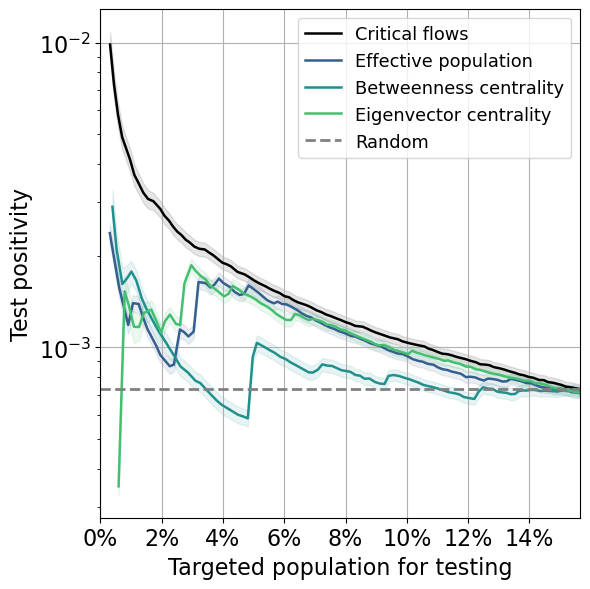

In [132]:
fig,ax = plt.subplots(figsize=(6,6))
label_size = 16
abc_size = 16*1.6

time_window = 30
betastr = '4,0'
nustr = '0,50'

transport = pd.read_csv('public_transport/times/out/bogota_transport_20k_30d_beta_' + betastr + f'_nu_{nustr}.txt', sep='\t')
transport_population = pd.read_csv('public_transport/times/out/transportHubPop/bogota_transport_20k_30d_beta_' + betastr + f'_nu_{nustr}.txt', sep='\t')
transport_betweenness_centrality = pd.read_csv('public_transport/times/out/betweenness/bogota_transport_20k_30d_beta_' + betastr + f'_nu_{nustr}.txt', sep='\t')
transport_eigen_centrality = pd.read_csv('public_transport/times/out/eigen_centrality/bogota_transport_20k_30d_beta_' + betastr + f'_nu_{nustr}.txt', sep='\t')

# smooth the curves

# transport['detected'] = transport['detected'].rolling(window=2).mean()
# transport_error = transport['error'].rolling(window=2).mean()

# transport_population['detected'] = transport_population['detected'].rolling(window=2).mean()
# transport_population['error'] = transport_population['error'].rolling(window=2).mean()

# transport_betweenness_centrality['detected'] = transport_betweenness_centrality['detected'].rolling(window=2).mean()
# transport_betweenness_centrality['error'] = transport_betweenness_centrality['error'].rolling(window=2).mean()

# transport_eigen_centrality['detected'] = transport_eigen_centrality['detected'].rolling(window=2).mean()
# transport_eigen_centrality['error'] = transport_eigen_centrality['error'].rolling(window=2).mean()

lower = transport['detected'].iloc[-1]

colormap = mpl.colormaps['viridis_r']

max_days,min_days = 17,9

total_tests = 20000 * time_window
errorNorm = 1/np.sqrt((24*8)-1)


ax.plot(transport['population'], transport['detected']/total_tests, label='Critical flows', c = 'black', lw=1.8)
ax.fill_between(x=transport['population'], y1=(transport['detected']+ errorNorm*transport['error'])/total_tests, y2=(transport['detected']-errorNorm*transport['error'])/total_tests, color='black', alpha=0.1)

ax.plot(transport_population['population'], transport_population['detected']/total_tests, label='Effective population', c = colormap(0.7), lw=1.8)
ax.fill_between(x=transport_population['population'], y1=(transport_population['detected']+ errorNorm*transport_population['error'])/total_tests, y2=(transport_population['detected']-errorNorm*transport_population['error'])/total_tests, color=colormap(0.7), alpha=0.1)

ax.plot(transport_betweenness_centrality['population'], transport_betweenness_centrality['detected']/total_tests, label='Betweenness centrality', c = colormap(0.50), lw=1.8)
ax.fill_between(x=transport_betweenness_centrality['population'], y1=(transport_betweenness_centrality['detected']+ errorNorm*transport_betweenness_centrality['error'])/total_tests, y2=(transport_betweenness_centrality['detected']-errorNorm*transport_betweenness_centrality['error'])/total_tests, color=colormap(0.50), alpha=0.1)

ax.plot(transport_eigen_centrality['population'], transport_eigen_centrality['detected']/total_tests, label='Eigenvector centrality', c = colormap(0.3), lw=1.8)
ax.fill_between(x=transport_eigen_centrality['population'], y1=(transport_eigen_centrality['detected']+ errorNorm*transport_eigen_centrality['error'])/total_tests, y2=(transport_eigen_centrality['detected']-errorNorm*transport_eigen_centrality['error'])/total_tests, color=colormap(0.30), alpha=0.1)


total_pop = cities_populations['bogota']
transport_pop = transport['population'].iloc[-1]

#Plot again the lines with alpha = 0 to set the legend
# ax.plot(links['population'], links['detected'], label='Links', alpha=0)
# ax.plot(transport['population'], transport['detected'], label='Transport', alpha=0)
ax.plot([0,7100000], [lower/total_tests, lower/total_tests], label='Random', c = 'grey', lw = 2, linestyle = 'dashed')

# labelLine(ax.get_lines()[-4], zorder=2.5, x=0.1*total_pop, outline_width=5, align=False, yoffset=0.001, color=colormap(0.8))
# labelLine(ax.get_lines()[-3], zorder=2.5, x=0.081*total_pop, outline_width=5, align=False, yoffset=0.0006, color='red')
# labelLine(ax.get_lines()[-2], zorder=2.5, x=0.04*total_pop, outline_width=5, align=False, yoffset=0.0005, color='black')
# labelLine(ax.get_lines()[-1], zorder=2.5, x=0.01*total_pop, outline_width=5, align=False, yoffset=0.00015, color='grey')

ax.legend(fontsize=label_size*0.8)


ax.set_xlabel('Targeted population for testing', size=label_size)
ax.set_ylabel('Test positivity', size=label_size)
ax.tick_params(labelsize=label_size)
ax.set_xlim(0, transport_pop)

# ax.set_ylim(0.0004,0.04)
# ax.set_ylim(0.0002,0.02)

ax.set_yscale('log')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

# ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, numticks=10))

percentages = np.array([0,2,4,6,8,10,12,14]) * total_pop / 100
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(percentages))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/total_pop*100) + '%'))

ax.grid('True')

fig.tight_layout()
fig.show()
fig.savefig(f'figures/figs_aug24/times/transport_beta{betastr}_nu{nustr}.pdf', bbox_inches='tight', dpi=300)

# SUPPLEMENTARY MATERIAL

## Extended data fig 2

In [26]:
def plot_args(function, links, out):
    fig,ax = plt.subplots(figsize=(6,6))
    function(links,ax)
    fig.savefig(out, bbox_inches='tight', dpi=300)

/tmp/ipykernel_1431/3428397289.py:65: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ZAT_destinations['total_tests_dest'] = (ZAT_destinations['chosen_dest'] / (ZAT_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']
/tmp/ipykernel_1431/3428397289.py:65: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ZAT_destinations['total_tests_dest'] = (ZAT_destinations['chosen_dest'] / (ZAT_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']
/tmp/ipykernel_1431/3428397289.py:65: FutureWarning: The default v

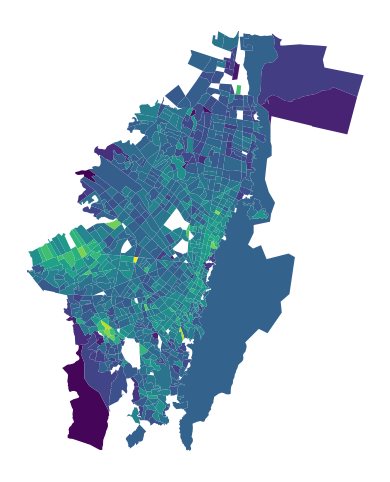

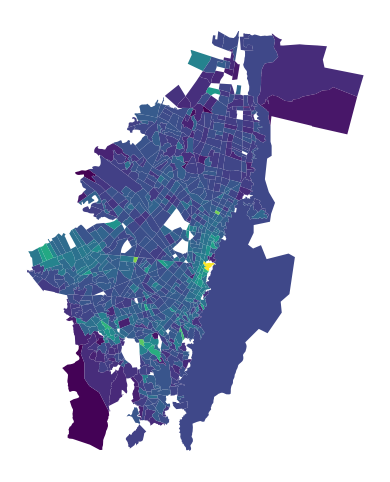

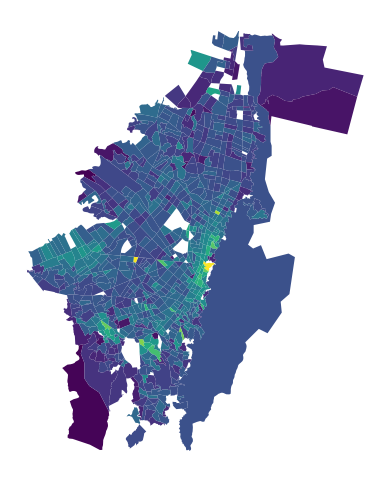

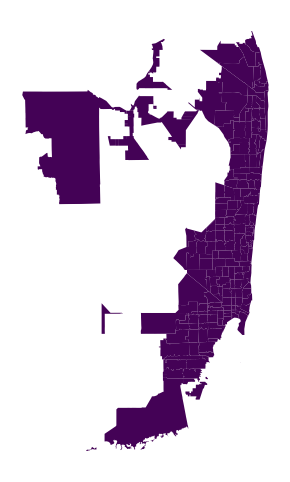

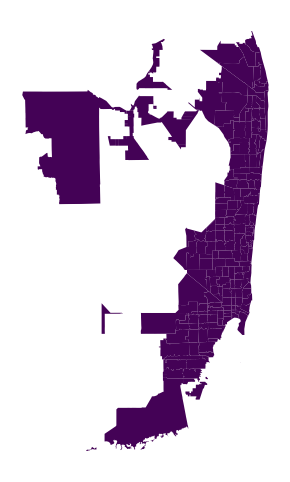

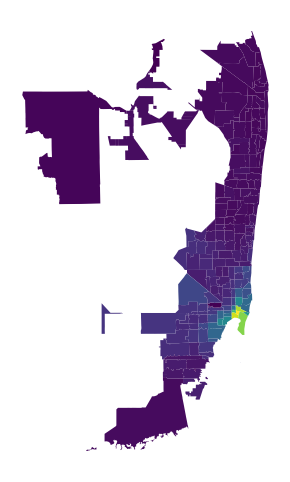

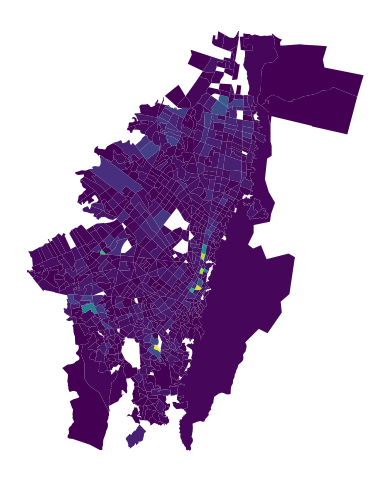

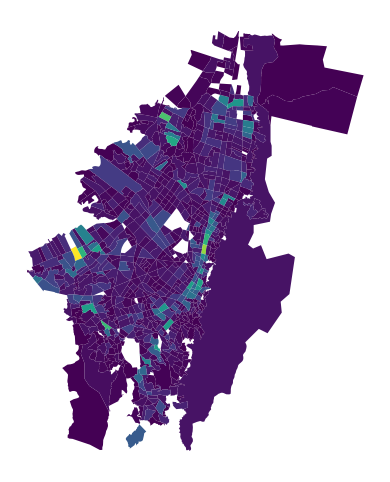

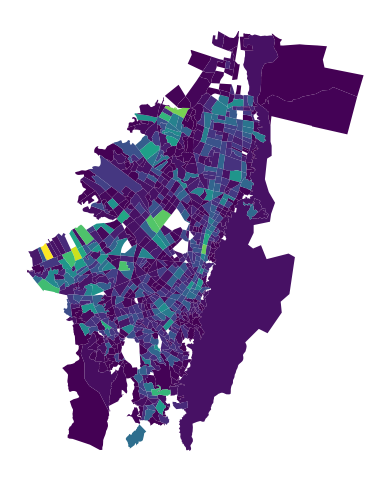

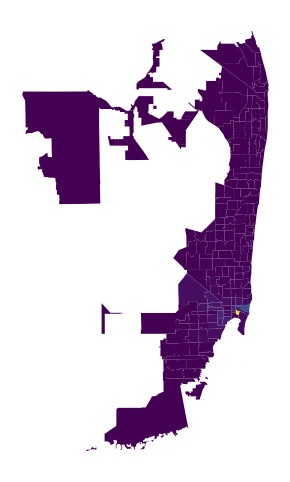

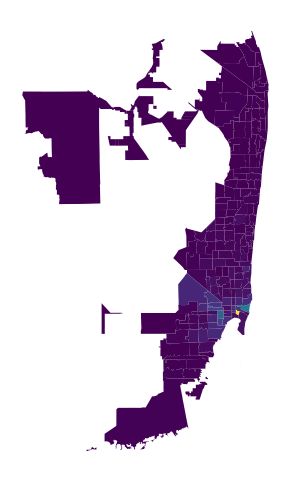

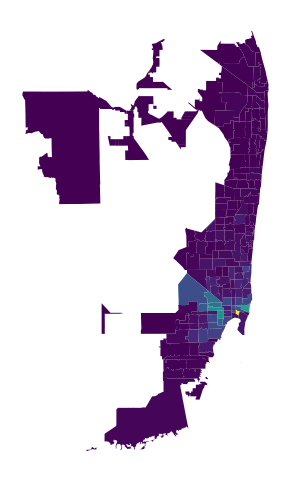

In [29]:

plot_args(plot_impact_map_bogota,'8k', 'figures/figs_feb24/supplementary/Supp2a.pdf');
plot_args(plot_impact_map_bogota,'28k', 'figures/figs_feb24/supplementary/Supp2b.pdf');
plot_args(plot_impact_map_bogota,'45k', 'figures/figs_feb24/supplementary/Supp2c.pdf');
plot_args(plot_impact_map_miami,'2k', 'figures/figs_feb24/supplementary/Supp2d.pdf');
plot_args(plot_impact_map_miami,'4k', 'figures/figs_feb24/supplementary/Supp2e.pdf');
plot_args(plot_impact_map_miami,'6k', 'figures/figs_feb24/supplementary/Supp2f.pdf');
plot_args(plot_links_bogota,'8000', 'figures/figs_feb24/supplementary/Supp2g.pdf');
plot_args(plot_links_bogota,'28000', 'figures/figs_feb24/supplementary/Supp2h.pdf');
plot_args(plot_links_bogota,'45000', 'figures/figs_feb24/supplementary/Supp2i.pdf');
plot_args(plot_links_miami,'2000', 'figures/figs_feb24/supplementary/Supp2j.pdf');
plot_args(plot_links_miami,'4000', 'figures/figs_feb24/supplementary/Supp2k.pdf');
plot_args(plot_links_miami,'6000', 'figures/figs_feb24/supplementary/Supp2l.pdf');

#figures/figs_feb24/individuales/Fig4f.pdf


In [11]:
plots = [
(plot_impact_map_bogota,'8k', 'figures/figs_feb24/supplementary/Supp2a.pdf'),
(plot_impact_map_bogota,'28k', 'figures/figs_feb24/supplementary/Supp2b.pdf'),
(plot_impact_map_bogota,'45k', 'figures/figs_feb24/supplementary/Supp2c.pdf'),
(plot_impact_map_miami,'2k', 'figures/figs_feb24/supplementary/Supp2d.pdf'),
(plot_impact_map_miami,'4k', 'figures/figs_feb24/supplementary/Supp2e.pdf'),
(plot_impact_map_miami,'6k', 'figures/figs_feb24/supplementary/Supp2f.pdf'),
(plot_links_bogota,'8000', 'figures/figs_feb24/supplementary/Supp2g.pdf'),
(plot_links_bogota,'28000', 'figures/figs_feb24/supplementary/Supp2h.pdf'),
(plot_links_bogota,'45000', 'figures/figs_feb24/supplementary/Supp2i.pdf'),
(plot_links_miami,'2000', 'figures/figs_feb24/supplementary/Supp2j.pdf'),
(plot_links_miami,'4000', 'figures/figs_feb24/supplementary/Supp2k.pdf'),
(plot_links_miami,'6000', 'figures/figs_feb24/supplementary/Supp2l.pdf')]

/tmp/ipykernel_18014/191910943.py:65: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ZAT_destinations['total_tests_dest'] = (ZAT_destinations['chosen_dest'] / (ZAT_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']
/tmp/ipykernel_18014/191910943.py:65: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ZAT_destinations['total_tests_dest'] = (ZAT_destinations['chosen_dest'] / (ZAT_destinations.sum()['chosen_dest']))# / ZAT_destinations['total_dest']
/tmp/ipykernel_18014/191910943.py:65: FutureWarning: The default v

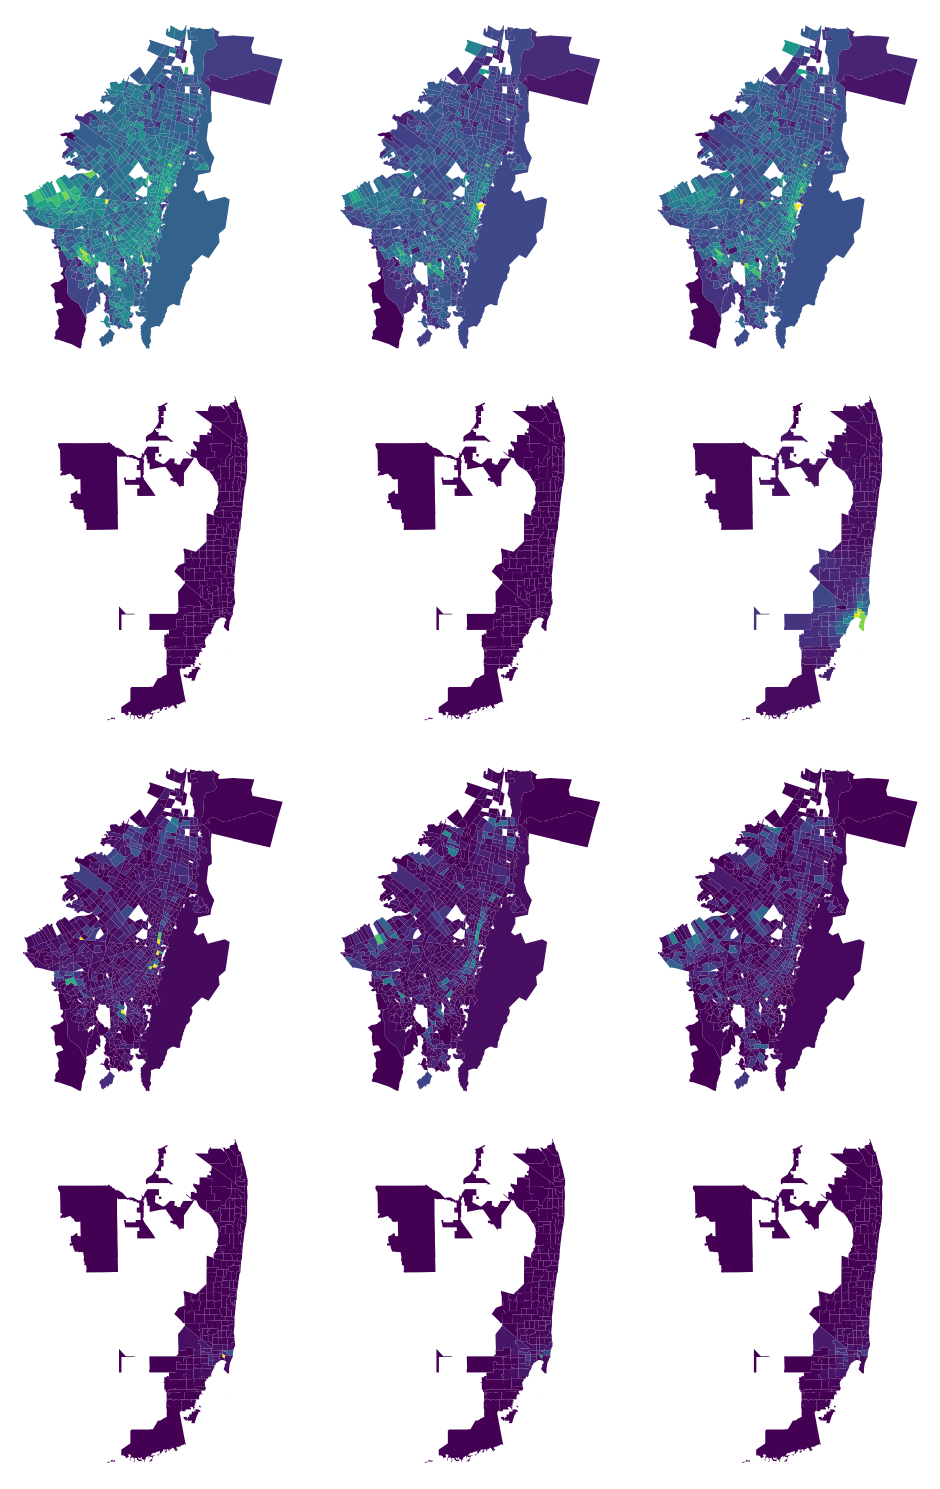

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(10, 15))
for ax,(function,links,output) in zip(axes.flatten(), plots):
    function(links, ax)

fig.subplots_adjust(left=0.0, right=1, top=1, bottom=0)
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
# for ax,label in zip(axes.flatten(), labels):
    # if label in ['d','e','f','j','k','l']:
    #     fig.text(-0.175, 1, '('+label+')', transform=ax.transAxes, fontsize=14, fontweight='bold', color='dimgrey')
    # else:
    #     fig.text(0, 1, '('+label+')', transform=ax.transAxes, fontsize=14, fontweight='bold', color='dimgrey')
#color the background of the axes

fig.tight_layout()

# fig.savefig('figures/figs_feb24/extended/extendedFig2.pdf', bbox_inches='tight', dpi=300)

In [14]:
fig.savefig('figures/figs_feb24/extended/extendedFig2.pdf', bbox_inches='tight', dpi=300)

## Extended data fig 3

In [5]:
def plot_kwargs(out, function, **kwargs):
    fig,ax = plt.subplots(figsize=(6,6))
    function(ax, **kwargs)
    fig.savefig(out, bbox_inches='tight', dpi=300)

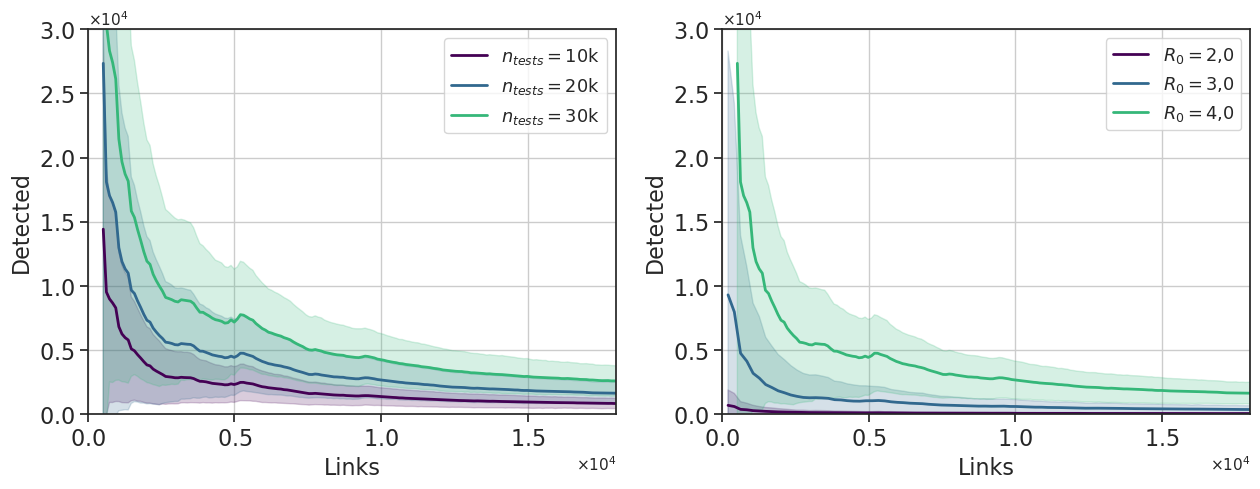

In [19]:
fig,[ax,ax1] = plt.subplots(1,2,figsize=(15,5))
plot_detected_tests(ax)
ax1.set_xlim(0,1.8e4)
ax1.set_ylim(0,3e4)
# fig.savefig('figures/figs_feb24/extended/extendedFig3a.pdf', bbox_inches='tight', dpi=300)

plot_detected_betas(ax1)
ax.set_xlim(0,1.8e4)
ax.set_ylim(0,3e4)
# fig.savefig('figures/figs_feb24/extended/extendedFig3b.pdf', bbox_inches='tight', dpi=300)


fig.savefig('figures/figs_feb24/extended/extendedFig3.png', bbox_inches='tight', dpi=300)
fig.savefig('figures/figs_feb24/extended/extendedFig3.pdf', bbox_inches='tight', dpi=300)


In [73]:
def plot_detailed_R0_reduction(ax, ax1, ax2):
    label_size = 16
    abc_size = 16*1.6

    colormap = mpl.colormaps['viridis_r']

    name = 'bogota'
    betastr = '4,0'

    curves = pd.read_csv('curves_times_reduction_R0/out/bogota_20k_180d_beta_4,0.txt', sep='\t')
    links_list = curves['links'].drop_duplicates().sort_values()
    curves['error_infected'] = curves['error_infected'] / np.sqrt(24-1)

    curves['cumulative_detected'] = curves.groupby('links')['detected'].cumsum(axis=0)

    # grouping by number of links, write the maximum number of infected
    max_infected = curves.groupby('links')['infected'].max().rolling(window=3).mean()
    attack_rates = curves.groupby('links')['infected'].sum().rolling(window=3).mean()
    # grouping by number of links, write the time at the maximum number of infected
    time_max_infected = curves.loc[curves.groupby('links')['infected'].idxmax()].set_index('links')['time'].rolling(window=3).mean()

    #set links as index
    max_infected.plot(ax=ax, color='black', lw=2);
    attack_rates.plot(ax=ax1, color='black', lw=2);
    time_max_infected.plot(ax=ax2, color='black', lw=2);

    ax.set_xlabel('L', size=label_size)
    ax.set_ylabel('Peak infected', size=label_size)
    ax.tick_params(labelsize=label_size)
    ax.grid('True')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

    ax1.set_xlabel('L', size=label_size)
    ax1.set_ylabel('Attack Rate', size=label_size)
    ax1.tick_params(labelsize=label_size)
    ax1.grid('True')
    ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

    ax2.set_xlabel('L', size=label_size)
    ax2.set_ylabel('Epidemic Peak Time', size=label_size)
    ax2.tick_params(labelsize=label_size)
    ax2.grid('True')
    ax2.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

    fig.tight_layout()

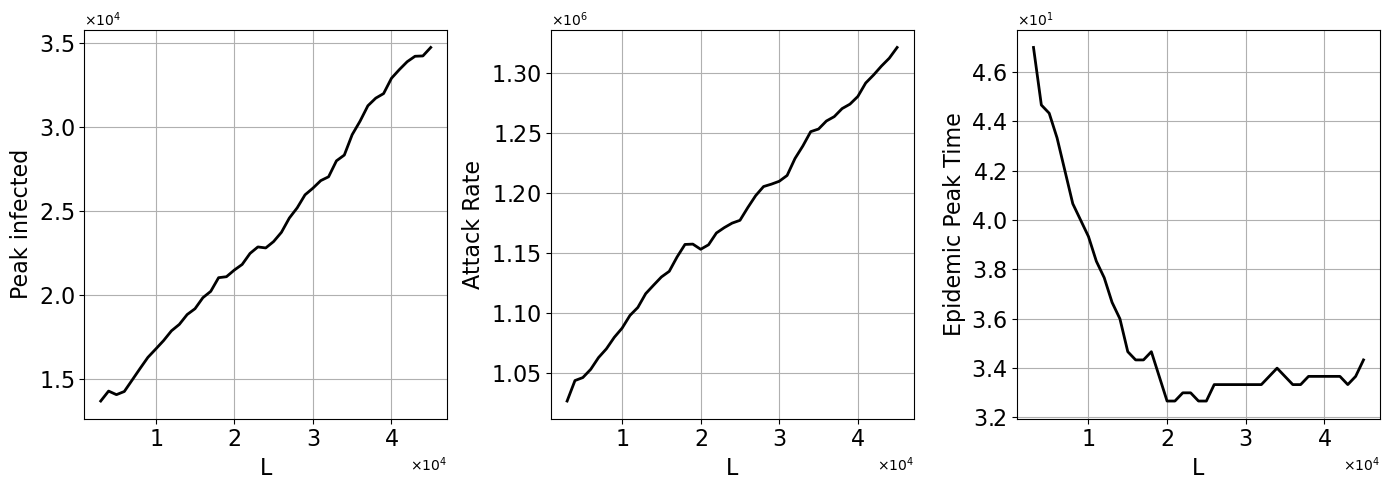

In [75]:
fig,[ax,ax1,ax2] = plt.subplots(1,3, figsize=(14,5))
plot_detailed_R0_reduction(ax, ax1, ax2);
fig.savefig('figures/figs_feb24/extended/extendedFig4.png', bbox_inches='tight', dpi=300)

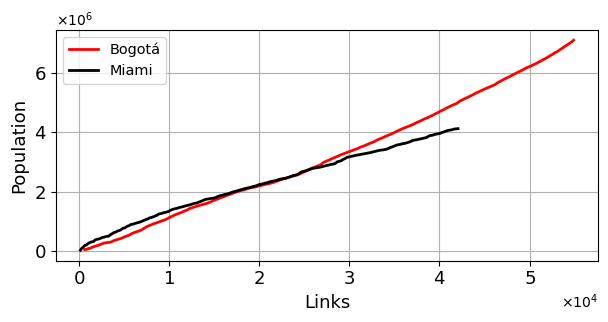

In [24]:
# Relation links-population
fig,ax = plt.subplots(figsize=(7,3))
label_size = 13
linkpop_bogota = pd.read_csv('times/out/bogota_30k_60d_beta_4,0.txt', sep='\t')
linkpop_bogota.plot(x='links', y='population', label=r'Bogotá', ax=ax, color='red', lw=2)

linkpop_miami = pd.read_csv('times/out/old/ma_30k_60d_beta_4,0.txt', sep='\t')
linkpop_miami.plot(x='links', y='population', label='Miami', ax=ax, color='black', lw=2)

ax.set_xlabel('Links', size=label_size)
ax.set_ylabel('Population', size=label_size)
ax.tick_params(labelsize=label_size)
ax.grid('True')
ax.legend(fontsize=label_size*0.8)
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

plt.savefig('figures/figs_feb24/supplementary/suppFig1.png', bbox_inches='tight', dpi=300)